In [15]:
"""
This labels the heads based on hypothesis testing.
We switch to a different visualization 
of the labelled heads diagram than the
one which appears here.
"""
import pickle as pkl
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import os
import pandas as pd
import itertools
from matplotlib import colors
import matplotlib.pyplot as plt
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)

num_sents = 20
num_layers, num_heads = 12, 12

In [16]:
# Z-test
def ztest_own(pop1, th, n, alternate='smaller'):
    mu1, v = np.mean(pop1), np.std(pop1) 
    z = (mu1 - th)/(v/np.sqrt(n))
    df = n - 1
    rv = st.t(df)
    if alternate == 'larger':
        return rv.cdf(z)
    else:
        #print('here')
        return 1 - rv.cdf(z)
def get_pvals(sent_set, attention_scores, uniform_baseline_score):
    pvals = np.zeros([num_layers, num_heads])
    for l in range(num_layers):
        for h in range(num_heads):
            single_head_scores, baseline = [], []
            for s in sent_set:
                single_head_scores.append(attention_scores[s][l,h])
                baseline.append(uniform_baseline_score[s])
            if len(baseline) != len(single_head_scores):
                raise "Population sizes are different."
            score = ztest_own(single_head_scores, baseline[0], len(baseline))
            pvals[l,h] = score
    return pvals

In [17]:
def init(task_name):
    input_file='./texts/glue_data_{}_test_small.tsv'.format(task_name.upper())
    attn_file1='./pkl_dir/attention_weights_{}_small.pkl'.format(task_name)
    task_name=task_name
    
    # Read attention weights file.
    a = pkl.load(open(attn_file1, 'rb'))
    print("len of a {}".format(len(a)))
    print("shape of a {}".format(a[0].shape))
    
    # Read text file.
    f = open(input_file, 'r')
    f1 = f.readlines()
    f1 = f1[1:]   #Ignore the 1st row which has label.
    print("Total sentences in test set: {}".format(len(f1)))
    return f1, a

In [18]:
"""
task_name: QNLI/QQP/MRPC/SST-2
baseline: 1, 1.5, 2, 2.5, 3, 3.5
method: avg/pval
reln: nsubj/dobj/amod/advmod/all
"""
def get_selected_heads(task_name, baseline, method, output_dir, reln=None):
    
    baseline_score = [baseline for i in range(num_sents)]
    #print("task: {}-{}x".format(task_name, baseline))
    #loc2
    local_band2 = pkl.load(open(output_dir + 'local/' + "all_heads_all_sents_locbias_band2_{}.pkl".format(task_name), "rb"))
    if method == 'avg':
        avg_local = np.mean(local_band2, axis=0)
        loc2_heads = [i for i,x in enumerate(np.reshape(avg_local, [num_layers*num_heads,])) if x > baseline]
    elif method == 'pval':
        part_sents = np.arange(0,num_sents)
        pvals_local = get_pvals(part_sents, local_band2, baseline_score)
        #print(pvals_local)
        loc2_heads = [i for i,x in enumerate(np.reshape(pvals_local, [num_layers*num_heads,])) if x < 0.05]
    
    
    #no-op heads
    noop_scores = pkl.load(open(output_dir + 'delimiter/' +"all_heads_all_sents_noops_score_{}.pkl".format(task_name), "rb"))
    if method == 'avg':
        avg_noops = np.mean(noop_scores, axis=0)
        noop_heads = [i for i,x in enumerate(np.reshape(avg_noops, [num_layers*num_heads,])) if x > baseline]
    elif method == 'pval':
        part_sents = np.arange(0,num_sents)
        pvals_noops = get_pvals(part_sents, noop_scores, baseline_score)
        noop_heads = [i for i,x in enumerate(np.reshape(pvals_noops, [num_layers*num_heads,])) if x < 0.05]
        
    #no-op_cls heads
    noop_scores_cls = pkl.load(open(output_dir + 'delimiter/' +"all_heads_all_sents_noops_score_{}_subtype_CLS.pkl".format(task_name), "rb"))
    if method == 'avg':
        avg_noops_cls = np.mean(noop_scores_cls, axis=0)
        noop_heads_cls = [i for i,x in enumerate(np.reshape(avg_noops_cls, [num_layers*num_heads,])) if x > baseline]
    elif method == 'pval':
        part_sents = np.arange(0,num_sents)
        pvals_noops_cls = get_pvals(part_sents, noop_scores_cls, baseline_score)
        noop_heads_cls = [i for i,x in enumerate(np.reshape(pvals_noops_cls, [num_layers*num_heads,])) if x < 0.05]
        
    #no-op_sep heads
    noop_scores_sep = pkl.load(open(output_dir + 'delimiter/' + "all_heads_all_sents_noops_score_{}_subtype_SEP.pkl".format(task_name), "rb"))
    if method == 'avg':
        avg_noops_sep = np.mean(noop_scores_sep, axis=0)
        noop_heads_sep = [i for i,x in enumerate(np.reshape(avg_noops_sep, [num_layers*num_heads,])) if x > baseline]
    elif method == 'pval':
        part_sents = np.arange(0,num_sents)
        pvals_noops_sep = get_pvals(part_sents, noop_scores_sep, baseline_score)
        noop_heads_sep = [i for i,x in enumerate(np.reshape(pvals_noops_sep, [num_layers*num_heads,])) if x < 0.05]
        
    # Block heads
    if task_name == 'sst-2':
        block_heads = []
    else:
        block_scores = pkl.load(open(output_dir + 'block/' + "all_heads_all_sents_block_score_{}.pkl".format(task_name), 'rb'))
        if method == 'avg':
            avg_block = np.mean(block_scores, axis=0)
            block_heads = [i for i,x in enumerate(np.reshape(avg_block, [num_layers*num_heads,])) if x > baseline]
        elif method == 'pval':
            part_sents = np.arange(0,num_sents)
            pvals_block = get_pvals(part_sents, block_scores, baseline_score)
            block_heads = [i for i,x in enumerate(np.reshape(pvals_block, [num_layers*num_heads,])) if x < 0.05]
    
    if reln is None:
        return [loc2_heads, noop_heads, block_heads, noop_heads_cls, noop_heads_sep]
    
    #syn
    syn_band = pkl.load(open(output_dir + 'syntactic/' + "{}_all_heads_all_scores_{}.pkl".format(reln, task_name), "rb"))
    part_sents = pkl.load(open(output_dir + 'syntactic/' + "{}_participating_sents_{}.pkl".format(reln, task_name), "rb"))
    if method == 'avg':
        avg_syn = np.sum(syn_band, axis=0)/len(part_sents)
        syn_heads = [i for i,x in enumerate(np.reshape(avg_syn, [num_layers*num_heads,])) if x > baseline]
    elif method == 'pval':
        pvals_syn = get_pvals(part_sents, syn_band, baseline_score)
        syn_heads = [i for i,x in enumerate(np.reshape(pvals_syn, [num_layers*num_heads,])) if x < 0.05]
            
    
    return [syn_heads] 

In [19]:
def mark_specific_heads(x_loc, x_syn, task_name, baseline, later_layers):
    head_matrix = int(255)* np.ones((1, 72,3),dtype=int) #12*12
    loc_set, syn_set = set(x_loc), set(x_syn)
    both_loc_syn = loc_set.intersection(syn_set)
    only_loc = loc_set - syn_set
    only_syn = syn_set - loc_set
#     print(loc_set)
#     print(syn_set)
#     print(only_loc)
#     print(only_syn)
    for x in list(both_loc_syn):
        if later_layers:
            x = x % 72
        head_matrix[0][x][0] = 255
        head_matrix[0][x][1] = 0
        head_matrix[0][x][2] = 255
    for x in list(only_loc):
        if later_layers:
            x = x % 72
        head_matrix[0][x][0] = 255
        head_matrix[0][x][1] = 0
        head_matrix[0][x][2] = 0
    for x in list(only_syn):
        if later_layers:
            x = x % 72
        head_matrix[0][x][0] = 0
        head_matrix[0][x][1] = 0
        head_matrix[0][x][2] = 255
    with plt.style.context("seaborn-white"):
        fig, ax = plt.subplots()
    #fig, ax = plt.figure()
    fig.set_figheight(50)
    fig.set_figwidth(100)
    #plt.minorticks_on()
    plt.rc('xtick',labelsize=40)
    dpi = 200
    locs = np.arange(0, 72)
    labels = [str(x) for x in np.arange(0, 72)]
    for axis in [ax.xaxis]:
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    # Turn on the grid for the minor ticks
    ax.grid(True, which='minor', lw=2, color='black')
    plt.yticks([])
    plt.xlabel('Head',color='black', fontsize=40)
    plt.ylabel('Layer',color='black', fontsize=40)
    plt.title('{}: {}'.format(task_name, baseline),color='black', fontsize=40)
    plt.imshow(head_matrix)
    plt.legend(['both', 'loc', 'nsubj'])

In [20]:
"""
This labels all the heads with respective
categories.
Arg: Sets of labelled heads belonging to various sets. input_cats = [loc_heads, syn_heads, noop_heads]
Returns: A dataframe with each head labelled with a category.
"""
def label_all_heads_in_DF(input_cats):
    cat_set_labels = ['layer', 'head', 'loc', 'syn', 'noop', 'nsubj', 'dobj', 'amod', 'advmod', 'block', 
                      'delim_cls', 'delim_sep']
    layer_head = itertools.product(np.arange(num_layers), np.arange(num_heads))
    data_arr =  [(x,y) for (x,y) in layer_head]
    temp_arr = -1* np.ones([len(data_arr), len(cat_set_labels)-2])
    data_for_df = pd.DataFrame(data=np.concatenate([data_arr, temp_arr], axis=1), columns=cat_set_labels)

    for i,single_set in enumerate(input_cats):
        for ele in single_set:
            l, h = int(ele / num_layers), int(ele % num_heads)
            data_for_df.loc[(data_for_df['layer'] == l) & (data_for_df['head'] == h), cat_set_labels[i+2]] = 1
    print(data_for_df)
    return data_for_df

TASK: qnli, BASELINE3
     layer  head  loc  syn  noop  nsubj  dobj  amod  advmod  block  delim_cls  \
0      0.0   0.0 -1.0 -1.0  -1.0   -1.0  -1.0  -1.0    -1.0    1.0       -1.0   
1      0.0   1.0 -1.0 -1.0  -1.0   -1.0  -1.0  -1.0    -1.0    1.0        1.0   
2      0.0   2.0 -1.0 -1.0  -1.0   -1.0  -1.0  -1.0    -1.0    1.0       -1.0   
3      0.0   3.0  1.0  1.0  -1.0    1.0  -1.0   1.0    -1.0   -1.0       -1.0   
4      0.0   4.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0    1.0       -1.0   
..     ...   ...  ...  ...   ...    ...   ...   ...     ...    ...        ...   
139   11.0   7.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0   -1.0       -1.0   
140   11.0   8.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0   -1.0       -1.0   
141   11.0   9.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0   -1.0       -1.0   
142   11.0  10.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0   -1.0       -1.0   
143   11.0  11.0 -1.0 -1.0   1.0   -1.0  -1.0  -1.0    -1.0   -1.0       -1.0   

     

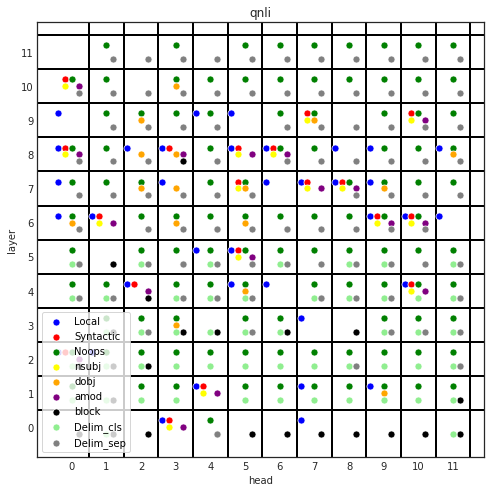

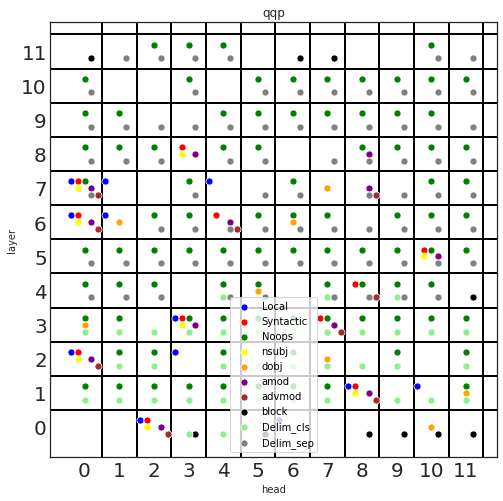

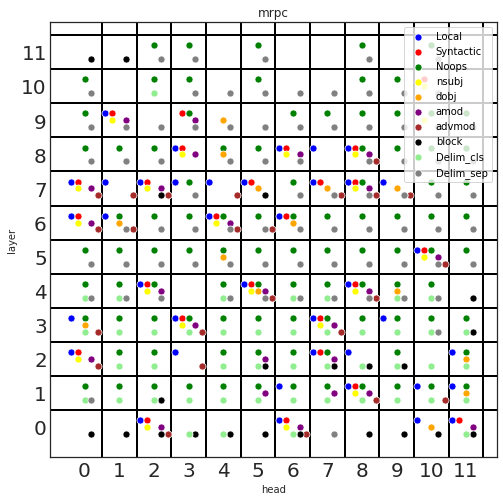

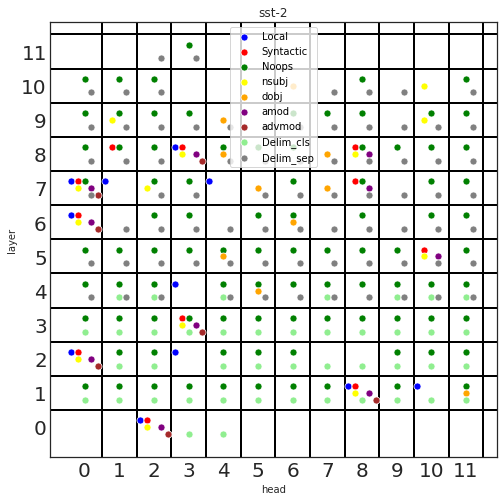

In [22]:
# Which heads are local, syntactic etc. No syntactic only head?
output_dir = './sieve_scores/'
for (task_name, baseline) in  itertools.product(['qnli', 'qqp', 'mrpc', 'sst-2'], [3]): #[1,1.5,2,2.5,3,3.5]
    print("TASK: {}, BASELINE{}".format(task_name, baseline))
    
    result1 = get_selected_heads(task_name, baseline, 'pval', output_dir, None)
    local_band2, noop_heads, block_heads = result1[0], result1[1], result1[2]
    noop_heads_cls, noop_heads_sep = result1[3], result1[4]
    all_heads = get_selected_heads(task_name, baseline, 'pval', output_dir, 'all')
    nsubj_heads  = get_selected_heads(task_name, baseline, 'pval', output_dir, 'nsubj')
    dobj_heads = get_selected_heads(task_name, baseline, 'pval', output_dir, 'dobj')
    amod_heads = get_selected_heads(task_name, baseline, 'pval', output_dir, 'amod')
    advmod_heads = get_selected_heads(task_name, baseline, 'pval', output_dir, 'advmod')
    
    data_for_df = label_all_heads_in_DF([local_band2, all_heads[0], noop_heads, nsubj_heads[0], dobj_heads[0], amod_heads[0], advmod_heads[0], 
                                         block_heads, noop_heads_cls, noop_heads_sep])
    if task_name == 'qnli':
        data_for_df_qnli = data_for_df
        
    if task_name == 'qqp':
        data_for_df_qqp = data_for_df
        
    if task_name == 'mrpc':
        data_for_df_mrpc = data_for_df
        
    if task_name == 'sst-2':
        data_for_df_sst2 = data_for_df
        
    with plt.style.context("seaborn-white"):
        fig, ax = plt.subplots()
    #fig, ax = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    #plt.minorticks_on()
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    #ax.xaxis.grid(color='black', which='minor')
    #ax.yaxis.grid(True, which='minor',color='black')
    #ax.xaxis.grid(True,color='black')
    dpi = 200
    locs = np.arange(0, 12)
    labels = [str(x) for x in np.arange(0, 12)]
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    #ax.yaxis.set(ticks=locs,ticklabels=labels)
    # Turn on the grid for the minor ticks
    ax.grid(True, which='minor', lw=2, color='black')
    layer_data = data_for_df.loc[data_for_df['loc'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['loc'] == 1]['head']
    g=sns.scatterplot(x=head_data-0.4, y=layer_data+0.2, color='Blue', s=50, label="Local")
    
    layer_data = data_for_df.loc[data_for_df['syn'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['syn'] == 1]['head']
    g=sns.scatterplot(x=head_data-0.2, y=layer_data+0.2, color='Red', s=50, label="Syntactic")
    
    layer_data = data_for_df.loc[data_for_df['noop'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['noop'] == 1]['head']
    g=sns.scatterplot(x=head_data, y=layer_data+0.2, color='Green', s=50, label="Noops")
    
    layer_data = data_for_df.loc[data_for_df['nsubj'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['nsubj'] == 1]['head']
    g=sns.scatterplot(x=head_data-0.2, y=layer_data, color='Yellow', s=50, label="nsubj")
    
    layer_data = data_for_df.loc[data_for_df['dobj'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['dobj'] == 1]['head']
    g=sns.scatterplot(x=head_data, y=layer_data, color='Orange', s=50, label="dobj")
    
    layer_data = data_for_df.loc[data_for_df['amod'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['amod'] == 1]['head']
    g=sns.scatterplot(x=head_data+0.2, y=layer_data, color='Purple', s=50, label="amod")
    
    layer_data = data_for_df.loc[data_for_df['advmod'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['advmod'] == 1]['head']
    g=sns.scatterplot(x=head_data+0.4, y=layer_data-0.2, color='Brown', s=50, label="advmod")
    
    layer_data = data_for_df.loc[data_for_df['block'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['block'] == 1]['head']
    g=sns.scatterplot(x=head_data+0.2, y=layer_data-0.2, color='Black', s=50, label="block")
    
    layer_data = data_for_df.loc[data_for_df['delim_cls'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['delim_cls'] == 1]['head']
    g=sns.scatterplot(x=head_data, y=layer_data-0.2, color='Lightgreen', s=50, label="Delim_cls")
    
    layer_data = data_for_df.loc[data_for_df['delim_sep'] == 1]['layer']
    head_data = data_for_df.loc[data_for_df['delim_sep'] == 1]['head']
    g=sns.scatterplot(x=head_data+0.2, y=layer_data-0.2, color='Gray', s=50, label="Delim_sep")
    
    
    plt.title(task_name)
    #plt.savefig("all_gems_map_{}.png".format(task_name), bbox_inches="tight")


#     g=sns.scatterplot(data=data_for_df.loc[data_for_df['loc'] == 1], x=data_for_df['head']-0.2, y='layer', color='Blue', s=50, label="Local")
#     g=sns.scatterplot(data=data_for_df.loc[data_for_df['syn'] == 1], x=data_for_df['head']+0, y='layer', color='Red', s=50, label="Syntactic")
#     g=sns.scatterplot(data=data_for_df.loc[data_for_df['noop'] == 1], x=data_for_df['head']+0.2, y='layer', color='Green', s=50, label="Noops")
#     g=sns.scatterplot(data=data_for_df.loc[data_for_df['nsubj'] == 1], x=data_for_df['head']+0.4, y='layer', color='Yellow', s=50, label="nsubj")
#     g=sns.scatterplot(data=data_for_df.loc[data_for_df['dobj'] == 1], x=data_for_df['head']-0.4, y=data_for_df['layer'], color='Orange', s=50, label="dobj")

    

In [23]:
data_for_df_qnli

,layer,head,loc,syn,noop,nsubj,dobj,amod,advmod,block,delim_cls,delim_sep
0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
1,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0
2,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
3,0.0,3.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
4,0.0,4.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
139,11.0,7.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
140,11.0,8.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
141,11.0,9.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
142,11.0,10.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [24]:
only_dobj_heads = data_for_df_qnli.loc[(data_for_df_qnli['dobj']==1) & (data_for_df_qnli['nsubj']==-1)][['layer', 'head']].to_numpy()
only_nsubj_heads = data_for_df_qnli.loc[(data_for_df_qnli['dobj']==-1) & (data_for_df_qnli['nsubj']==1)][['layer', 'head']].to_numpy()

In [25]:
data_for_df_mrpc.loc[(data_for_df_qnli["noop"]!=1)&(data_for_df_qnli["delim_cls"]==1)]

,layer,head,loc,syn,noop,nsubj,dobj,amod,advmod,block,delim_cls,delim_sep
1,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
11,0.0,11.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
13,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
40,3.0,4.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0


In [26]:
extra_pad = -1*np.ones([144,1])
qnli_gems_data = data_for_df_qnli.to_numpy()[:,2:]
qnli_gems_data = np.concatenate([qnli_gems_data, extra_pad], axis=1)
print(qnli_gems_data)
print(qnli_gems_data.shape)
pkl.dump(qnli_gems_data, open(output_dir + "qnli_gems.pkl", 'wb'))

qqp_gems_data = data_for_df_qqp.to_numpy()[:,2:]
qqp_gems_data = np.concatenate([qqp_gems_data, extra_pad], axis=1)
print(qqp_gems_data)
print(qqp_gems_data.shape)
pkl.dump(qqp_gems_data, open(output_dir + "qqp_gems.pkl", 'wb'))

mrpc_gems_data = data_for_df_mrpc.to_numpy()[:,2:]
mrpc_gems_data = np.concatenate([mrpc_gems_data, extra_pad], axis=1)
print(mrpc_gems_data)
print(mrpc_gems_data.shape)
pkl.dump(mrpc_gems_data, open(output_dir + "mrpc_gems.pkl", 'wb'))

sst2_gems_data = data_for_df_sst2.to_numpy()[:,2:]
sst2_gems_data = np.concatenate([sst2_gems_data, extra_pad], axis=1)
print(sst2_gems_data)
print(sst2_gems_data.shape)
pkl.dump(sst2_gems_data, open(output_dir + "sst2_gems.pkl", 'wb'))

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ...  1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1.  1. ... -1.  1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]]
(144, 11)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1.  1. -1.]]
(144, 11)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1.  1. ... -1.  1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
(144, 11)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
(144, 11)
